# Preprocessing (standardisation, one hot encoding, train test split)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
np.random.seed(72)

In [2]:
# read in the cleaned data
packages = pd.read_csv("../data/packages_final.csv")

# drop some columns which were needed for the cleaning process, but we don't need anymore for the analysis
# (and the columns with data about tertiary education and number of firms since there is no data for the year 2021)
packages.drop(columns=["E", "N", "bfs_no", "share_tertiary", "firms"], inplace=True)

# separate the independent (target) and dependent variables (features)
X_data = packages.drop(columns=["packages", "month", "weekday"])
target = packages["packages"]

# standardisation of dependent variables
standard = preprocessing.scale(X_data)

In [3]:
# We have variables that are in string format, however, in statistical models we need our dataset to only 
# include numerical values!

# get all the string columns, which should only be month and weekday if everything is correct
str_cols = [col for col in packages.columns if packages[col].dtype == "O"]

# create the one hot encoding dummy variables
packages = pd.get_dummies(packages, columns=str_cols)


In [4]:
# turn the array (X_data) back into a data frame
packages_st = pd.DataFrame(standard, columns=X_data.columns)

# new data set that includes the dummy variables + the target
dummy = packages.drop(columns=packages.columns[1:16])

# add the month/weekday/packages columns...
packages_st = pd.concat([packages_st, dummy], axis=1)

# display the complete standardised and one hot encoded dataset and save it
packages_st.head()
# packages_st.to_csv("../data/packages_st.csv", index=False)

,mean_age,total_pop,share_0to14,share_15to19,share_20to39,share_40to64,share_65to79,share_above80,share_foreigners,share_catholics,...,month_November,month_October,month_September,weekday_DI,weekday_DO,weekday_FR,weekday_MI,weekday_MO,weekday_SA,weekday_SO
0,-2.041805,-0.545104,2.232769,-0.205094,0.362606,-0.614213,-2.265277,0.025105,-1.137106,1.408947,...,0,0,0,1,0,0,0,0,0,0
1,-2.041805,-0.545104,2.232769,-0.205094,0.362606,-0.614213,-2.265277,0.025105,-1.137106,1.408947,...,0,0,0,0,1,0,0,0,0,0
2,-2.041805,-0.545104,2.232769,-0.205094,0.362606,-0.614213,-2.265277,0.025105,-1.137106,1.408947,...,0,0,0,0,0,1,0,0,0,0
3,-2.041805,-0.545104,2.232769,-0.205094,0.362606,-0.614213,-2.265277,0.025105,-1.137106,1.408947,...,0,0,0,0,0,0,1,0,0,0
4,-2.041805,-0.545104,2.232769,-0.205094,0.362606,-0.614213,-2.265277,0.025105,-1.137106,1.408947,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# sklearn provides a nifty function to split train/test sets
from sklearn.model_selection import train_test_split

# Split X and y: X dependent variables (features), y the traget variable
X = packages_st.drop("packages", axis=1)
y = packages_st["packages"]

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=72, shuffle=True)

# Training and Testing the Models

In [6]:
# Import all the models from sklearn we want to implement:
from sklearn.linear_model import LinearRegression # we start with the most basic model, a linear regression
from sklearn.linear_model import ElasticNetCV # next, we use ElasticNet, again a linear regression model, 
# however, one that is regularised, i.e., one that penalises the model for the weights it chooses. 
# ElasticNet is a mixture of Lasso and Ridge, it combines absolute and squared penalties for the weights!
# ElasticNetCV means that it already uses cross validation to iteratively find the best fit (for the alpha parameter and l1_ratio)
from sklearn.svm import SVR # our last model that is kind of similar to linear regression, 
# however, does not yield a particular prediction (as in linear regression) but gives a threshold of values
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# all the models we want to use in a dictionary
models = {
    "LinearRegression": LinearRegression(),
    "ElasticNetCV": ElasticNetCV(l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], cv=5),
    "SupportedVectorRegressor": SVR(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoostRegressor": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor()
}

# train our models with the Xtrain and ytrain data!
print("---------Training---------")
for name, model in models.items():
    model.fit(Xtrain, ytrain)
    print(name + " trained!")
print("-----------Done-----------")

---------Training---------
LinearRegression trained!
ElasticNetCV trained!
SupportedVectorRegressor trained!
RandomForest trained!
GradientBoostRegressor trained!
XGBoost trained!
-----------Done-----------


In [7]:
# import sklearn functions we use to evaluate the accurateness of our models
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import time
from datetime import timedelta

# dictionary to collect the results
train_result_dict = {}

# for the prediction, we loop through our model dictionary 
for name, model in models.items():
    start_time = time.monotonic()
    ypred = model.predict(Xtrain)
    end_time = time.monotonic()
    print(timedelta(seconds=end_time - start_time))
    print(name + "\n   R2: {:.2f} %".format(r2_score(ytrain, ypred)*100))
    print("   MAE: {:.2f}".format(mae(ytrain, ypred)))
    print("   MSE: {:.2f}".format(mse(ytrain, ypred)))
    train_result_dict[name] = [r2_score(ytrain, ypred)*100,
                        mae(ytrain, ypred),
                        mse(ytrain, ypred)]
    print("----------------------------------------------------")

0:00:00.002337
LinearRegression
   R2: 68.22 %
   MAE: 937.21
   MSE: 4022898.02
----------------------------------------------------
0:00:00.001420
ElasticNetCV
   R2: 67.94 %
   MAE: 918.69
   MSE: 4057711.46
----------------------------------------------------
0:00:02.161322
SupportedVectorRegressor
   R2: -2.57 %
   MAE: 1310.85
   MSE: 12982243.87
----------------------------------------------------
0:00:00.125093
RandomForest
   R2: 99.53 %
   MAE: 87.88
   MSE: 59812.09
----------------------------------------------------
0:00:00.009523
GradientBoostRegressor
   R2: 96.86 %
   MAE: 330.60
   MSE: 397458.23
----------------------------------------------------
0:00:00.015766
XGBoost
   R2: 99.83 %
   MAE: 96.59
   MSE: 21817.49
----------------------------------------------------


In [8]:
# collect the results for our testing data
test_result_dict = {}

# loop through the dictionary, however, this time with the testing data
for name, model in models.items():
    start_time = time.monotonic()
    ypred = model.predict(Xtest)
    end_time = time.monotonic()
    print(timedelta(seconds=end_time - start_time))
    print(name + "\n   R2: {:.2f} %".format(r2_score(ytest, ypred)*100))
    print("   MAE: {:.2f}".format(mae(ytest, ypred)))
    print("   MSE: {:.2f}".format(mse(ytest, ypred)))
    test_result_dict[name] = [r2_score(ytest, ypred)*100,
                        mae(ytest, ypred),
                        mse(ytest, ypred)]
    print("----------------------------------------------------")
    

0:00:00.001915
LinearRegression
   R2: 71.78 %
   MAE: 947.30
   MSE: 4115714.29
----------------------------------------------------
0:00:00.001364
ElasticNetCV
   R2: 71.54 %
   MAE: 927.75
   MSE: 4151022.50
----------------------------------------------------
0:00:00.915919
SupportedVectorRegressor
   R2: -2.77 %
   MAE: 1366.59
   MSE: 14990017.64
----------------------------------------------------
0:00:00.065816
RandomForest
   R2: 96.87 %
   MAE: 235.72
   MSE: 456926.25
----------------------------------------------------
0:00:00.004901
GradientBoostRegressor
   R2: 96.76 %
   MAE: 339.07
   MSE: 472701.88
----------------------------------------------------
0:00:00.008017
XGBoost
   R2: 97.55 %
   MAE: 210.10
   MSE: 357648.93
----------------------------------------------------


Text(0.5, 1.02, 'Model Evaluation')

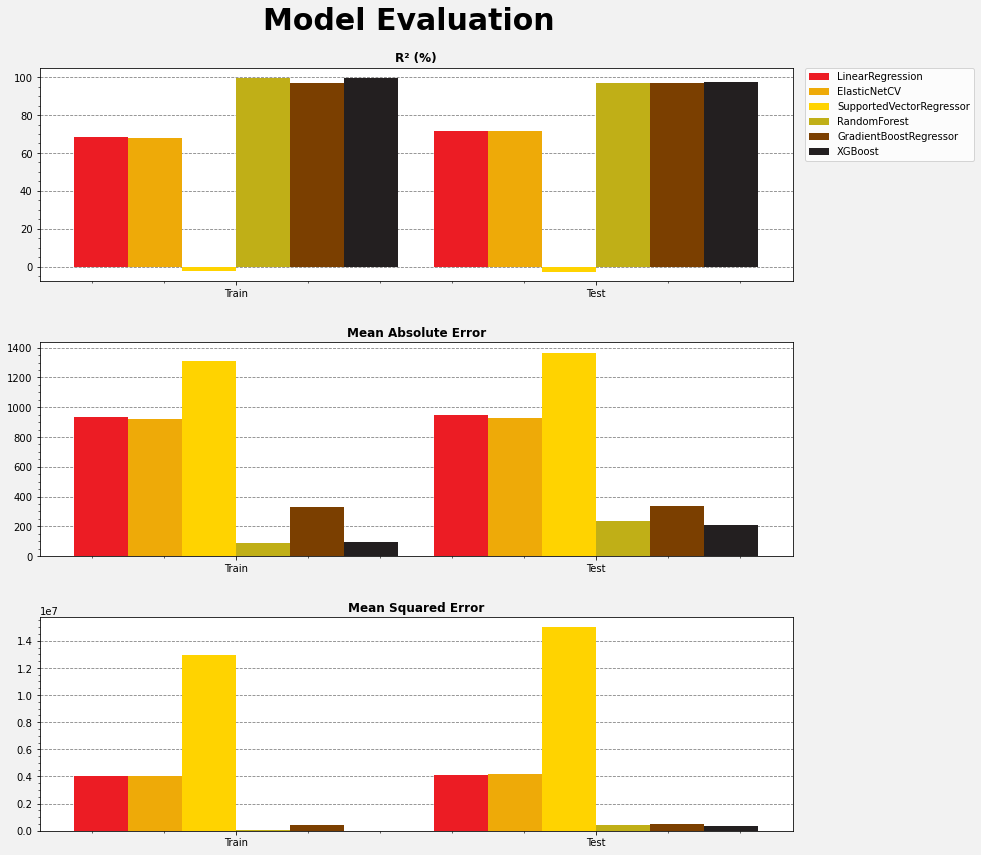

In [9]:
# Here, we create plots for our model evaluation. We compare (1) between the chosen models and 
# (2) between the results for the train and the test split, respectively

# create figure and axes
fig, axs = plt.subplots(3, 1, figsize=(12, 12), facecolor="#f2f2f2")
fig.tight_layout(pad=4.0)
width = 0.15

# loop through our result dictionaries, n.b. we chose the colours that represent those from the Swiss Post ;)
for i in range(3):
    labs = [f"{model}" for model in models.keys()] if i == 0 else ["" for _ in range(1, 7)]
    axs[i].bar(0 + 0 * width, train_result_dict["LinearRegression"][i], width, label=labs[0], color="#ec1c24")
    axs[i].bar(0 + 1 * width, train_result_dict["ElasticNetCV"][i], width, label=labs[1], color="#eeaa08")
    axs[i].bar(0 + 2 * width, train_result_dict["SupportedVectorRegressor"][i], width, label=labs[2], color="#ffd300")
    axs[i].bar(0 + 3 * width, train_result_dict["RandomForest"][i], width, label=labs[3], color="#c0af17")
    axs[i].bar(0 + 4 * width, train_result_dict["GradientBoostRegressor"][i], width, label=labs[4], color="#7B3F00")
    axs[i].bar(0 + 5 * width, train_result_dict["XGBoost"][i], width, label=labs[5], color="#231f20")
    axs[i].bar(1 + 0 * width, test_result_dict["LinearRegression"][i], width, color="#ec1c24")
    axs[i].bar(1 + 1 * width, test_result_dict["ElasticNetCV"][i], width, color="#eeaa08")
    axs[i].bar(1 + 2 * width, test_result_dict["SupportedVectorRegressor"][i], width, color="#ffd300")
    axs[i].bar(1 + 3 * width, test_result_dict["RandomForest"][i], width, color="#c0af17")
    axs[i].bar(1 + 4 * width, test_result_dict["GradientBoostRegressor"][i], width, color="#7B3F00")
    axs[i].bar(1 + 5 * width, test_result_dict["XGBoost"][i], width, color="#231f20")

# Set titles for the respective subplots
axs[0].set_title("R² (%)", weight = "bold")
axs[1].set_title("Mean Absolute Error", weight = "bold")
axs[2].set_title("Mean Squared Error", weight = "bold")

# Labels, legend, and some beautifications
for ax in axs:
    ax.set_xticks([2.5*width , 2.5*width + 1], ["Train", "Test"])
fig.legend(bbox_to_anchor=(1.16, 0.955))
for i in range(3):
    axs[i].grid(axis="y", linestyle="--", color="gray")
    axs[i].set_axisbelow(True)
    axs[i].minorticks_on()
fig.suptitle("Model Evaluation", weight="bold", fontsize=30, y=1.02)


# Discovering Feature Importance for RF, GBR, and XGBR

The most important features are: ['mean_age', 'total_pop', 'share_20to39', 'share_40to64', 'month_December', 'weekday_MO', 'weekday_SA', 'weekday_SO'] 

The most important features are: ['total_pop', 'share_20to39', 'share_40to64', 'distance_to_nearest_city', 'weekday_MO', 'weekday_SA', 'weekday_SO'] 

The most important features are: ['mean_age', 'total_pop', 'distance_to_nearest_city', 'month_December', 'weekday_MO', 'weekday_SA', 'weekday_SO'] 



Text(0.48, 1.02, 'Most Important Features per Model')

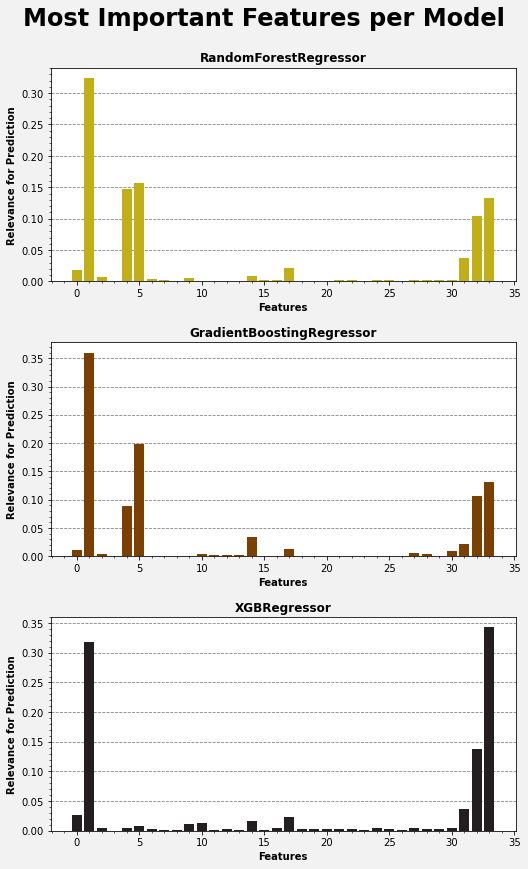

In [10]:
# For our top 3 models, we want to find out the importance they associate with each feature

# list with the three best models
best_models = [RandomForestRegressor(), GradientBoostingRegressor(), XGBRegressor()]

# create figure, axes, and color list 
fig, axs = plt.subplots(3, 1, figsize=(8, 12), facecolor="#f2f2f2")
fig.tight_layout(pad=4.0)
colorlist = ["#c0af17", "#7B3F00", "#231f20"]

# create a list with the feature names so we can access them by index
feature_names = np.array(X.columns.tolist())

# loop over the top three models, and distill feature importance
for i in range(3):
    best_models[i].fit(Xtrain, ytrain)
    importance = best_models[i].feature_importances_
    #for j,v in enumerate(importance):
        #print('Feature: %0d, Score: %.5f' % (j,v))
    # print all features that have a weight of more than 0.015, the features refer to the respective models that are in the above order
    print(f"The most important features are: {[feature_names[i] for i in range(len(importance)) if importance[i] > 0.015]} \n")
    axs[i].bar([x for x in range(len(importance))], importance, color=colorlist[i])

# Set the respective model as title
axs[0].set_title("RandomForestRegressor", weight = "bold")
axs[1].set_title("GradientBoostingRegressor", weight = "bold")
axs[2].set_title("XGBRegressor", weight = "bold")

# Grid, labels for axes, and some beautifications
for i in range(3):
    axs[i].grid(axis="y", linestyle="--", color="gray")
    axs[i].minorticks_on()
    axs[i].set_axisbelow(True)
    axs[i].set_xlabel("Features", weight="bold")
    axs[i].set_ylabel("Relevance for Prediction", weight="bold")
fig.suptitle("Most Important Features per Model", weight="bold", fontsize=24, x=0.48, y=1.02)


In [11]:
feature_names

array(['mean_age', 'total_pop', 'share_0to14', 'share_15to19',
       'share_20to39', 'share_40to64', 'share_65to79', 'share_above80',
       'share_foreigners', 'share_catholics', 'share_other_relig',
       'share_protestants', 'unemployment_rate', 'taxpower',
       'distance_to_nearest_city', 'month_April', 'month_August',
       'month_December', 'month_February', 'month_January', 'month_July',
       'month_June', 'month_March', 'month_May', 'month_November',
       'month_October', 'month_September', 'weekday_DI', 'weekday_DO',
       'weekday_FR', 'weekday_MI', 'weekday_MO', 'weekday_SA',
       'weekday_SO'], dtype='<U24')

# Cross Validation with XGBoost

In [12]:
# short input on cross validation to find out the optimal number of boosting rounds
# import the whole xgb package to access the built-in cv function 
import xgboost as xgb

# converting our data into a dmatrix
dmatrix = xgb.DMatrix(data=Xtrain, label=ytrain)

# we only set the objective function to mean squared error as parameter in xgb
params = {"objective": "reg:squarederror"}
# apply the xgb.cv() method on the data, we use 5 folds, stop the process as soon as no better result can be
# obtained after 10 rounds, and use the mae as evaluation metric
xgb_cv = xgb.cv(dtrain = dmatrix, params = params, nfold = 5, num_boost_round = 1000, 
                early_stopping_rounds = 10, metrics="mae", as_pandas = True, seed=72)

# inspect the results:
xgb_cv.tail(5)
# --> our model performs best with 134 boosting iterations!

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
130,72.546502,1.245115,222.527858,16.640441
131,72.170382,1.237217,222.431771,16.647915
132,71.715055,1.158110,222.442562,16.755945
133,71.281602,1.223497,222.349706,16.738966
134,70.933253,1.177464,222.262472,16.854969


Text(0.5, 0, 'Round')

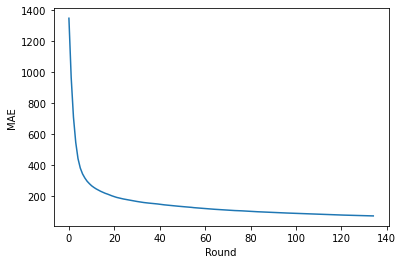

In [13]:
# visualise the result
plt.plot(xgb_cv.iloc[:,0])
plt.ylabel("MAE")
plt.xlabel('Round')

In [18]:
# applying the result found to our model, i.e., setting the n_estimators = 134 and see...
xgb_best = XGBRegressor(objective="reg:squarederror", n_estimators=134)

# fit the model
xgb_best.fit(Xtrain, ytrain)

# make the predictions
start_time = time.monotonic()
ypred_train = xgb_best.predict(Xtrain)
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

start_time = time.monotonic()
ypred_test = xgb_best.predict(Xtest)
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))


# printing the evaluation resluts
print("Training \n   R2: {:.2f} %".format(r2_score(ytrain, ypred_train)*100))
print("   MAE: {:.2f}".format(mae(ytrain, ypred_train)))
print("   MSE: {:.2f}".format(mse(ytrain, ypred_train)))
print("\nTesting \n   R2: {:.2f} %".format(r2_score(ytest, ypred_test)*100))
print("   MAE: {:.2f}".format(mae(ytest, ypred_test)))
print("   MSE: {:.2f}".format(mse(ytest, ypred_test)))

0:00:00.022131
0:00:00.009588
Training 
   R2: 99.89 %
   MAE: 79.83
   MSE: 13899.47

Testing 
   R2: 97.60 %
   MAE: 207.81
   MSE: 349991.37


# Testing Different Objective Functions for XGBoost 

In [15]:
# for our best model, the XGBRegressor, we want to find out whether we could get an even better result 
# if we change the objective function. That is, the standard is MSE, now we try Huberloss & MAE

# XGB with pseudohubererror
objective_f = ["reg:pseudohubererror", "reg:absoluteerror", "reg:gamma"]

for function in objective_f:
    xgb_f = XGBRegressor(objective = function)
    xgb_f.fit(Xtrain, ytrain)
    start_time = time.monotonic()
    ypred_f = xgb_f.predict(Xtrain)
    end_time = time.monotonic()
    print(timedelta(seconds=end_time - start_time))
    print(f"For the objective function {function}: \nR2 score: {r2_score(ytrain, ypred_f)*100:.2f}% \nMAE: {mae(ytrain, ypred_f):.2f} \nMSE: {mse(ytrain, ypred_f):.2f}")
    start_time = time.monotonic()
    ypred_2f = xgb_f.predict(Xtest)
    end_time = time.monotonic()
    print(timedelta(seconds=end_time - start_time))
    print(f"For objective function {function}: \nR2 score: {r2_score(ytest, ypred_2f)*100:.2f}% \nMAE: {mae(ytest, ypred_2f):.2f} \nMSE: {mse(ytest, ypred_2f):.2f} \n")



0:00:00.017603
For the objective function reg:pseudohubererror: 
R2 score: 25.47% 
MAE: 726.19 
MSE: 9433203.04
0:00:00.009010
For objective function reg:pseudohubererror: 
R2 score: 23.56% 
MAE: 808.88 
MSE: 11149756.86 

0:00:00.013984
For the objective function reg:absoluteerror: 
R2 score: -4.20% 
MAE: 1375.22 
MSE: 13187647.62
0:00:00.007203
For objective function reg:absoluteerror: 
R2 score: -4.02% 
MAE: 1426.11 
MSE: 15173411.10 

0:00:00.015044
For the objective function reg:gamma: 
R2 score: 99.36% 
MAE: 112.85 
MSE: 81320.61
0:00:00.007729
For objective function reg:gamma: 
R2 score: 98.58% 
MAE: 170.96 
MSE: 206922.24 

